## MNIST Dataset
####  (Modified National Institute of Standards and Technology database)



[The MNIST Database](http://yann.lecun.com/exdb/mnist/) was a result of the US Post Office's desire to automate the routing of mail by using machine learning to analyze handwitten zip codes. It is a large database of handwritten digits that is commonly used for training various image processing systems. It is also widely used for training and testing in the field of machine learning. 


We will analyze the data and create a convolutional neural network that is capable of predicting the correct label for the numbers in the dataset.

The MNIST dataset contains 60,000 training and 10,000 testing images, each a grayscale image of 28x28 pixels.

#### We will be using Keras with Tensorflow as the backend.

In [2]:
import keras
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import models
from keras.utils import to_categorical
from keras.datasets import mnist

%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


### Loading the Data

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images array shape is {} and train_labels shape is {} '.format(train_images.shape, train_labels.shape))
print('test_images array shape is {} and test_labels shape is {} '.format(test_images.shape, test_labels.shape))

train_images array shape is (60000, 28, 28) and train_labels shape is (60000,) 
test_images array shape is (10000, 28, 28) and test_labels shape is (10000,) 


### Data Analysis

#### Sample Images:

![Example](Images/01_01.jpg)

#### Label Distribution Histograms:

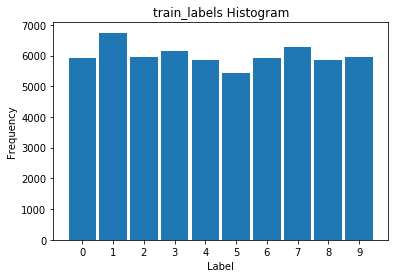

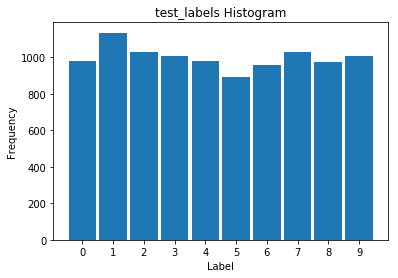

In [4]:
plt.hist(train_labels, bins=range(11), rwidth=.9, align='left')
plt.xticks(range(10))
plt.title('train_labels Histogram')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

plt.hist(test_labels, bins=range(11), rwidth=.9, align='left')
plt.xticks(range(10))
plt.title('test_labels Histogram')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

Histograms look fairly balanced, with an equal distribution of labels.

#### Random Samples of the Dataset:

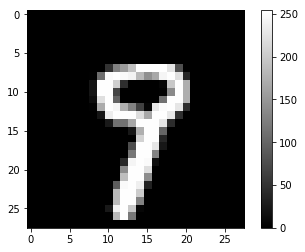

The image label is 9


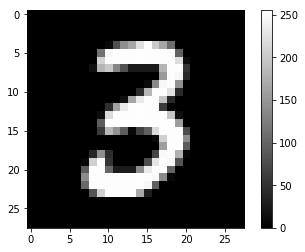

The image label is 3


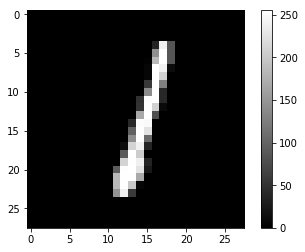

The image label is 1


In [4]:
for i in range(3):
    index = random.randrange(test_images.shape[0])
    
    plt.imshow(test_images[index], cmap='gray')
    plt.colorbar()
    plt.show()
    
    print('The image label is {}'.format(test_labels[index]))

### Converting Data to Floating Point

In [5]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

### Scaling Data

This is important step, since neural networks are typically used with floating point pixel values in [0, 1] range. Other ranges are also possible, for example [-1, 1] is another popular selection. Original image pixel values are [0, 255] so the scaling can be done by dividing the values by 255.

In [6]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

### One-hot Encoding the Label Vectors

In classification tasks the data labels are very often encoded in one-hot format. For example, label 6 is encoded as [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]. This allows the labels to be dealt with in a uniform way since they are all represented by isomorphic data structures.

The neural network uses this same format to output the prediction results.

In [7]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

index = 47

print(train_labels[index])
print('The above data label is {}.'.format(np.argmax(train_labels[index])))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
The above data label is 5.


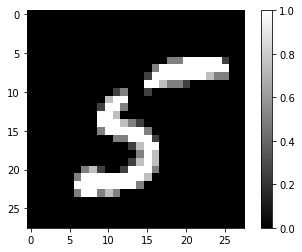

In [8]:
plt.imshow(train_images[47].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

### Creating a Convolutional Neural Network Model

This is what a basic convnet looks like. It is a stack of Conv2D and MaxPooling2D layers.

The convnet takes input tensors of this shape:

- image_height (rows)

- image_width (columns)

- image_channels (color channels)



In this case, we'll configure the convnet to process inputs of size (28, 28, 1), which is the format of MNIST images.

The convolutional layers extract elementary features of the images. These layers use the typical 3 x 3 filter size.

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', \
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#### Architecture of the Convnet:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


After the last Conv2D layer the 3D feature array is flattened to 1D vector, which is then connected to dense layers. The purpose of the dense layers is to use the elementary image feature information from convolutional layers and combine individual features so that it can perform the classification task.

The activation functions on the Dense layers are ReLU and Softmax.

In [11]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

### Network-Compilation Step

categorical_crossentropy is the loss function that is used as a feedback signal for learning the weight tensors. The training phase will attempt to minimize the loss. This reduction of the loss happens via mini-batch stochastic gradient descent.

The rules governing a specific use of gradient descent are defined by the rmsprop optimizer passed as the first argument.

In [13]:
model.compile(optimizer='rmsprop',\
             loss='categorical_crossentropy',\
             metrics=['accuracy'])

### Training Loop

Training is performed in epochs. Each iteration over all the training data is called an epoch. At the end of the epoch the testing data is used to calculate the model accuracy.

The network will start to iterate on the training data in mini-batches of 64 samples, 5 times over.

At each iteration, the network will compute the gradients of the weights with regard to the loss on the batch, and update the weights accordingly.

In [14]:
fit = model.fit(train_images, train_labels, epochs=5, batch_size=64,\
                validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 33s 556us/step - loss: 0.1680 - acc: 0.9471 - val_loss: 0.0500 - val_acc: 0.9831
Epoch 2/5
60000/60000 [==============================] - 34s 560us/step - loss: 0.0472 - acc: 0.9850 - val_loss: 0.0373 - val_acc: 0.9876
Epoch 3/5
60000/60000 [==============================] - 33s 556us/step - loss: 0.0331 - acc: 0.9898 - val_loss: 0.0321 - val_acc: 0.9893
Epoch 4/5
60000/60000 [==============================] - 34s 559us/step - loss: 0.0246 - acc: 0.9923 - val_loss: 0.0302 - val_acc: 0.9899
Epoch 5/5
60000/60000 [==============================] - 34s 564us/step - loss: 0.0198 - acc: 0.9942 - val_loss: 0.0243 - val_acc: 0.9918


### Test Accuracy

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

test_acc

10000/10000 [==============================] - 2s 216us/step


0.9918

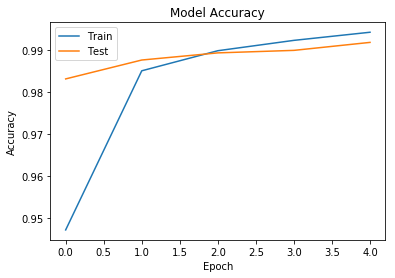

In [16]:
plt.plot(fit.history['acc'])
plt.plot(fit.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

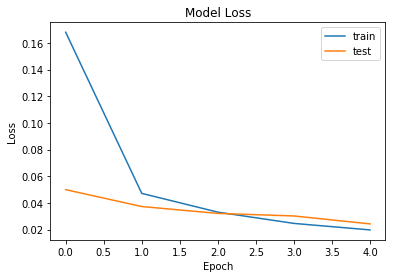

In [17]:
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

-----

### Making Predictions:

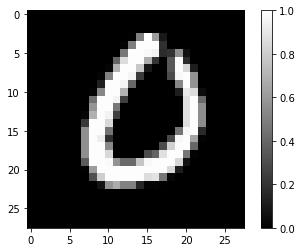

The image label is 0
The model prediction is 0


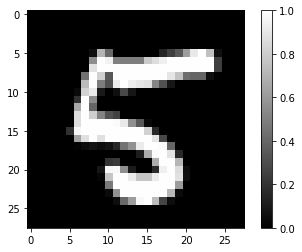

The image label is 5
The model prediction is 5


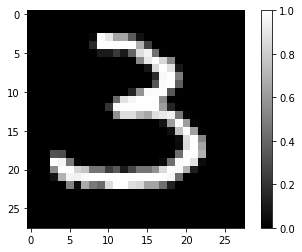

The image label is 3
The model prediction is 3


In [18]:
for i in range(3):
    index = random.randrange(test_images.shape[0])
    
    plt.imshow(test_images[index].reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()
    
    prediction = model.predict(np.expand_dims(test_images[index], axis=0))

    print('The image label is {}'.format(np.argmax(test_labels[index])))
    print('The model prediction is {}'.format(np.argmax(prediction)))

### On Failure:

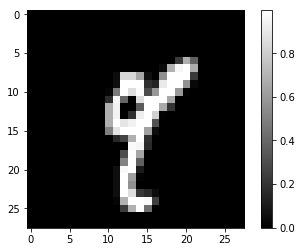

The prediction is 2
The actual number is 9


In [37]:
while True: 
    index = random.randrange(test_images.shape[0])   
    prediction = np.argmax(model.predict(np.expand_dims(test_images[index], axis=0)))
    real = np.argmax(test_labels[index])
    if prediction != real:
        break
    
plt.imshow(test_images[index].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

print('The prediction is {}'.format(pred))
print('The actual number is {}'.format(real))